# Check SWOT data in the cloud

Jinbo Wang

Revision history
1. Created on - 04/03/2023 J.W.
1. Revised for SMCE platform - 04/28/2023 J.W.

## System configuration 
Load the python libraries and setup the AWS S3FS object for reading data directly from cloud. Make sure you have the .netrc file in your root directory with your earthdata login account and password. You can follow these steps if you have not done so: https://podaac.github.io/tutorials/external/NASA_Earthdata_Authentication.html. 

In [3]:
import pprint
import xarray as xr
import netCDF4 as nc4
import pylab as plt
from scipy import signal
import numpy as np
import swot_ssh_utils as swot
import hvplot.pandas  # noqa
import hvplot.xarray  # noqa
import cartopy.crs as ccrs
import holoviews as hv
import warnings
warnings.filterwarnings('ignore')

def init_S3FileSystem():
    import requests
    import s3fs
    
    # Get authentication credentials from a JSON file
    creds = requests.get('https://archive.swot.podaac.earthdata.nasa.gov/s3credentials').json()
    
    # Initialize an S3FileSystem instance with the credentials
    s3 = s3fs.S3FileSystem(anon=False,
                           key=creds['accessKeyId'],
                           secret=creds['secretAccessKey'], 
                           token=creds['sessionToken'])
    
    # Return the S3FileSystem instance
    return s3
def plotit(ax,lon,lat,dat,vmin=-0.15,vmax=0.15):
    proj = ccrs.PlateCarree()
    extent = [lon.min(),lon.max(), lat.min(),lat.max()]
    # Add the scatter plot
    lon=lon.data.flatten()
    lat=lat.data.flatten()
    ax.scatter(lon, lat, c=dat, s=1, cmap=plt.cm.bwr,
               transform=ccrs.PlateCarree(),
              vmin=-0.15,vmax=0.15)
    ax.coastlines(resolution='110m')
    ax.gridlines(draw_labels=True)
    ax.set_extent(extent, proj)
    return
    
# Call the init_S3FileSystem function and assign the result to a variable named s3sys
s3sys = init_S3FileSystem()

lat_bounds=[34,37]
pass_number = '013' #California 
#pass_number = '026' #California 
pass_number='017';lat_bounds=[-6.5,-4.5]

#Med-sea
#pass_number='003';latmin=38.5;latmax=41.1
#pass_num='016';latmin=36.5;latmax=43.5
#pass_number='016';latmin=38.5;latmax=41.1

#lat_bounds=[latmin,latmax]
#thresshold_std=0.267

The following block searches for SWOT Expert data product and displays the names of the most recent four NetCDF files within PODAAC cloud.

The ss='SWOT_L2_LR_SSH_1.0' specify the product collection short_name. 

"s3://podaac-swot-ops-cumulus-protected" is the podaac S3 bucket. 

## Basic product

In [10]:
product_type='Basic'

In [11]:
ss='SWOT_L2_LR_SSH_1.0/'
fns=s3sys.glob(f"s3://podaac-swot-ops-cumulus-protected/SWOT_L2_LR_SSH_1.0/*{product_type}*_{pass_number}_*.nc")

print(f"There are {len(fns)} files in the system. The most recent four files are the following.")
pprint.pprint(fns[-4:])

There are 90 files in the system. The most recent four files are the following.
['podaac-swot-ops-cumulus-protected/SWOT_L2_LR_SSH_1.0/SWOT_L2_LR_SSH_Basic_544_017_20230607T004843_20230607T013451_PIA1_01.nc',
 'podaac-swot-ops-cumulus-protected/SWOT_L2_LR_SSH_1.0/SWOT_L2_LR_SSH_Basic_545_017_20230608T003921_20230608T012529_PIA1_01.nc',
 'podaac-swot-ops-cumulus-protected/SWOT_L2_LR_SSH_1.0/SWOT_L2_LR_SSH_Basic_546_017_20230609T002959_20230609T011607_PIA1_01.nc',
 'podaac-swot-ops-cumulus-protected/SWOT_L2_LR_SSH_1.0/SWOT_L2_LR_SSH_Basic_547_017_20230610T002037_20230610T010645_PIA1_01.nc']


### Use the python class SSH_L2 to access to the prebuilt functions.

In [12]:
data=swot.SSH_L2()
data.load_data(fns[-1],lat_bounds=lat_bounds,s3sys=s3sys)
display(data.Basic)

<xarray.Dataset>
Dimensions:                                (num_lines: 112, num_pixels: 69,
                                            num_sides: 2)
Coordinates:
    latitude                               (num_lines, num_pixels) float64 -6...
    longitude                              (num_lines, num_pixels) float64 17...
Dimensions without coordinates: num_lines, num_pixels, num_sides
Data variables: (12/24)
    time                                   (num_lines) datetime64[ns] ...
    time_tai                               (num_lines) datetime64[ns] ...
    ssh_karin                              (num_lines, num_pixels) float64 ...
    ssh_karin_qual                         (num_lines, num_pixels) float64 ...
    ssh_karin_uncert                       (num_lines, num_pixels) float32 ...
    ssha_karin                             (num_lines, num_pixels) float64 ...
    ...                                     ...
    mean_sea_surface_cnescls               (num_lines, num_pixels) float64 ...
    mean_sea_surface_cnescls_uncert        (num_lines, num_pixels) float32 ...
    geoid                                  (num_lines, num_pixels) float64 ...
    internal_tide_hret                     (num_lines, num_pixels) float32 ...
    height_cor_xover                       (num_lines, num_pixels) float64 ...
    height_cor_xover_qual                  (num_lines, num_pixels) float32 ...
Attributes: (12/60)
    Conventions:                                   CF-1.7
    title:                                         Level 2 Low Rate Sea Surfa...
    source:                                        Ka-band radar interferometer
    history:                                       2023-06-12T22:33:34Z : Cre...
    platform:                                      SWOT
    reference_document:                            D-56407_SWOT_Product_Descr...
    ...                                            ...
    ellipsoid_flattening:                          0.0033528106647474805
    institution:                                   CNES
    references:                                    V1.1
    equator_time:                                  2023-06-10T00:41:13.758000Z
    equator_longitude:                             176.73
    product_version:                               01

### Plot the most recent 20 snapshots

<xarray.Dataset>
Dimensions:                                (num_lines: 112, num_pixels: 69,
                                            num_sides: 2)
Coordinates:
    latitude                               (num_lines, num_pixels) float64 -6...
    longitude                              (num_lines, num_pixels) float64 17...
Dimensions without coordinates: num_lines, num_pixels, num_sides
Data variables: (12/24)
    time                                   (num_lines) datetime64[ns] ...
    time_tai                               (num_lines) datetime64[ns] ...
    ssh_karin                              (num_lines, num_pixels) float64 ...
    ssh_karin_qual                         (num_lines, num_pixels) float64 ...
    ssh_karin_uncert                       (num_lines, num_pixels) float32 ...
    ssha_karin                             (num_lines, num_pixels) float64 ...
    ...                                     ...
    mean_sea_surface_cnescls               (num_lines, num_pixels) float64 ...
    mean_sea_surface_cnescls_uncert        (num_lines, num_pixels) float32 ...
    geoid                                  (num_lines, num_pixels) float64 ...
    internal_tide_hret                     (num_lines, num_pixels) float32 ...
    height_cor_xover                       (num_lines, num_pixels) float64 ...
    height_cor_xover_qual                  (num_lines, num_pixels) float32 ...
Attributes: (12/60)
    Conventions:                                   CF-1.7
    title:                                         Level 2 Low Rate Sea Surfa...
    source:                                        Ka-band radar interferometer
    history:                                       2023-06-09T22:22:51Z : Cre...
    platform:                                      SWOT
    reference_document:                            D-56407_SWOT_Product_Descr...
    ...                                            ...
    ellipsoid_flattening:                          0.0033528106647474805
    institution:                                   CNES
    references:                                    V1.1
    equator_time:                                  2023-06-07T01:09:20.307000Z
    equator_longitude:                             176.73
    product_version:                               01

<xarray.Dataset>
Dimensions:                                (num_lines: 112, num_pixels: 69,
                                            num_sides: 2)
Coordinates:
    latitude                               (num_lines, num_pixels) float64 -6...
    longitude                              (num_lines, num_pixels) float64 17...
Dimensions without coordinates: num_lines, num_pixels, num_sides
Data variables: (12/24)
    time                                   (num_lines) datetime64[ns] ...
    time_tai                               (num_lines) datetime64[ns] ...
    ssh_karin                              (num_lines, num_pixels) float64 ...
    ssh_karin_qual                         (num_lines, num_pixels) float64 ...
    ssh_karin_uncert                       (num_lines, num_pixels) float32 ...
    ssha_karin                             (num_lines, num_pixels) float64 ...
    ...                                     ...
    mean_sea_surface_cnescls               (num_lines, num_pixels) float64 ...
    mean_sea_surface_cnescls_uncert        (num_lines, num_pixels) float32 ...
    geoid                                  (num_lines, num_pixels) float64 ...
    internal_tide_hret                     (num_lines, num_pixels) float32 ...
    height_cor_xover                       (num_lines, num_pixels) float64 ...
    height_cor_xover_qual                  (num_lines, num_pixels) float32 ...
Attributes: (12/60)
    Conventions:                                   CF-1.7
    title:                                         Level 2 Low Rate Sea Surfa...
    source:                                        Ka-band radar interferometer
    history:                                       2023-06-10T22:58:56Z : Cre...
    platform:                                      SWOT
    reference_document:                            D-56407_SWOT_Product_Descr...
    ...                                            ...
    ellipsoid_flattening:                          0.0033528106647474805
    institution:                                   CNES
    references:                                    V1.1
    equator_time:                                  2023-06-08T00:59:58.158000Z
    equator_longitude:                             176.73
    product_version:                               01

<xarray.Dataset>
Dimensions:                                (num_lines: 112, num_pixels: 69,
                                            num_sides: 2)
Coordinates:
    latitude                               (num_lines, num_pixels) float64 -6...
    longitude                              (num_lines, num_pixels) float64 17...
Dimensions without coordinates: num_lines, num_pixels, num_sides
Data variables: (12/24)
    time                                   (num_lines) datetime64[ns] ...
    time_tai                               (num_lines) datetime64[ns] ...
    ssh_karin                              (num_lines, num_pixels) float64 ...
    ssh_karin_qual                         (num_lines, num_pixels) float64 ...
    ssh_karin_uncert                       (num_lines, num_pixels) float32 ...
    ssha_karin                             (num_lines, num_pixels) float64 ...
    ...                                     ...
    mean_sea_surface_cnescls               (num_lines, num_pixels) float64 ...
    mean_sea_surface_cnescls_uncert        (num_lines, num_pixels) float32 ...
    geoid                                  (num_lines, num_pixels) float64 ...
    internal_tide_hret                     (num_lines, num_pixels) float32 ...
    height_cor_xover                       (num_lines, num_pixels) float64 ...
    height_cor_xover_qual                  (num_lines, num_pixels) float32 ...
Attributes: (12/60)
    Conventions:                                   CF-1.7
    title:                                         Level 2 Low Rate Sea Surfa...
    source:                                        Ka-band radar interferometer
    history:                                       2023-06-11T22:17:10Z : Cre...
    platform:                                      SWOT
    reference_document:                            D-56407_SWOT_Product_Descr...
    ...                                            ...
    ellipsoid_flattening:                          0.0033528106647474805
    institution:                                   CNES
    references:                                    V1.1
    equator_time:                                  2023-06-09T00:50:35.975000Z
    equator_longitude:                             176.73
    product_version:                               01

<xarray.Dataset>
Dimensions:                                (num_lines: 112, num_pixels: 69,
                                            num_sides: 2)
Coordinates:
    latitude                               (num_lines, num_pixels) float64 -6...
    longitude                              (num_lines, num_pixels) float64 17...
Dimensions without coordinates: num_lines, num_pixels, num_sides
Data variables: (12/24)
    time                                   (num_lines) datetime64[ns] ...
    time_tai                               (num_lines) datetime64[ns] ...
    ssh_karin                              (num_lines, num_pixels) float64 ...
    ssh_karin_qual                         (num_lines, num_pixels) float64 ...
    ssh_karin_uncert                       (num_lines, num_pixels) float32 ...
    ssha_karin                             (num_lines, num_pixels) float64 ...
    ...                                     ...
    mean_sea_surface_cnescls               (num_lines, num_pixels) float64 ...
    mean_sea_surface_cnescls_uncert        (num_lines, num_pixels) float32 ...
    geoid                                  (num_lines, num_pixels) float64 ...
    internal_tide_hret                     (num_lines, num_pixels) float32 ...
    height_cor_xover                       (num_lines, num_pixels) float64 ...
    height_cor_xover_qual                  (num_lines, num_pixels) float32 ...
Attributes: (12/60)
    Conventions:                                   CF-1.7
    title:                                         Level 2 Low Rate Sea Surfa...
    source:                                        Ka-band radar interferometer
    history:                                       2023-06-12T22:33:34Z : Cre...
    platform:                                      SWOT
    reference_document:                            D-56407_SWOT_Product_Descr...
    ...                                            ...
    ellipsoid_flattening:                          0.0033528106647474805
    institution:                                   CNES
    references:                                    V1.1
    equator_time:                                  2023-06-10T00:41:13.758000Z
    equator_longitude:                             176.73
    product_version:                               01

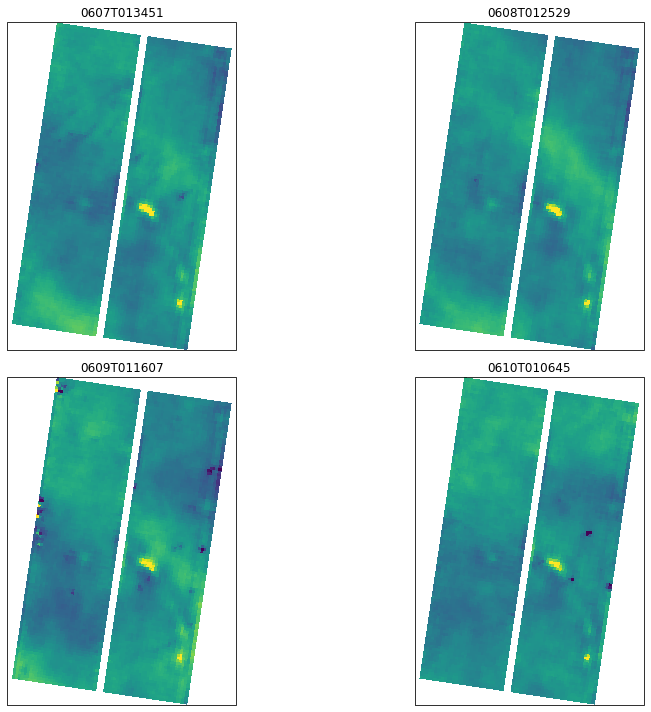

In [17]:
ni,nj=2,2
fig,ax=plt.subplots(ni,nj,figsize=(14,10),
                    subplot_kw={'projection': ccrs.PlateCarree()},
                    sharex=True,sharey=True)
axx=ax.flatten()

data=swot.SSH_L2()

for fn,ax0 in zip(fns[-ni*nj:],axx):
    data.load_data(fn,lat_bounds=lat_bounds,s3sys=s3sys)
    d=getattr(data,product_type)
    lon,lat=d['longitude'][:],d['latitude'][:]
    #The MSS in the product uses MSS15, which misses a lot of small-scale geoid. Replace it with MSS22 here:
    da=d['ssha_karin_2'][:]+d['mean_sea_surface_cnescls']-swot.get_mss22(lon.data, lat.data)
    da=da-np.nanmean(da,axis=0).reshape(1,-1)
    #plotit(ax0,lon,lat,da)
    display(d)
    #da[d['ssha_karin_2_qual'].data>0]=np.nan
    ax0.pcolor(lon,lat,da,vmin=-0.2,vmax=0.2)
    ax0.set_title(fn.split('_')[-3][4:15])
plt.tight_layout()

## Expert product

Expert product combines Basic and WindWave products together. The whole workflow is the same as above for the Expert product. I include all code in one block. The plot has ssha_karin_2 and sig0_karin_2.

In [ ]:
product_type='Expert'
ss='SWOT_L2_LR_SSH_1.0/'
fns=s3sys.glob(f"s3://podaac-swot-ops-cumulus-protected/SWOT_L2_LR_SSH_1.0/*{product_type}*_{pass_number}_*.nc")

print(f"There are {len(fns)} files in the system. The most recent four files are the following.")
pprint.pprint(fns[-4:])
data=swot.SSH_L2()
data.load_data(fns[-1],lat_bounds=lat_bounds,s3sys=s3sys)
display(getattr(data,product_type))

ni,nj=2,5
fig,ax=plt.subplots(ni,nj,figsize=(14,8),
                    subplot_kw={'projection': ccrs.PlateCarree()},
                    sharex=True,sharey=True)
axx=ax.flatten()

data=swot.SSH_L2()
for i in range(nj):
    data.load_data(fns[-i-1],lat_bounds=lat_bounds,s3sys=s3sys)
    d=getattr(data,product_type)
    lon,lat=d['longitude'][:],d['latitude'][:]
    #The MSS in the product uses MSS15, which misses a lot of small-scale geoid. Replace it with MSS22 here:
    da=d['ssha_karin_2'][:]+d['mean_sea_surface_cnescls']-swot.get_mss22(lon.data, lat.data)-2*d['sea_state_bias_cor_2'].data
    da=da-np.nanmean(da,axis=0).reshape(1,-1)
    #ax[0,i].scatter(lon,lat,c=da,s=2,vmin=-0.12,vmax=0.12,)
    ax[0,i].pcolor(lon,lat,da,vmin=-0.12,vmax=0.12,)
    
    da=d['sig0_karin_2'][:]
    da=da-np.nanmean(da,axis=0).reshape(1,-1)
    dam=np.nanmedian(da)
    dda = np.nanstd(da)
    ax[1,i].scatter(lon,lat,c=da,s=2,cmap=plt.cm.binary,vmin=dam-dda*2,vmax=dam+dda*2)
    
    ax[0,i].set_title(fn.split('_')[-3][4:15])
plt.tight_layout()


In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import swot_ssh_utils as swot

s3sys=swot.init_S3FileSystem()
product_type='Unsmoothed'
ss='SWOT_L2_LR_SSH_2.0'
fns=s3sys.glob(f"s3://podaac-swot-ops-cumulus-protected/{ss}/*{product_type}*_{pass_number}_*.nc")
dd=swot.SSH_L2()
print(len(fns),fns[-1])

product_type='Expert'
fns=s3sys.glob(f"s3://podaac-swot-ops-cumulus-protected/{ss}/*{product_type}*_{pass_number}_*.nc")

print(f"There are {len(fns)} files in the system. The most recent four files are the following.")
pprint.pprint(fns[-4:])
data=swot.SSH_L2()
data.load_data(fns[-1],lat_bounds=lat_bounds,s3sys=s3sys)
display(getattr(data,product_type))

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))
land = cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='gray')
#bathymetry = cfeature.NaturalEarthFeature('physical', 'bathymetry', '110m', edgecolor='face', facecolor=cfeature.COLORS['water'])

ax.add_feature(land)

data=swot.SSH_L2()
data.load_data(fns[-2],lat_bounds=lat_bounds,s3sys=s3sys)
d=getattr(data,product_type)
lon,lat=d['longitude'][:],d['latitude'][:]
#The MSS in the product uses MSS15, which misses a lot of small-scale geoid. Replace it with MSS22 here:
da=d['ssha_karin_2'][:]+d['height_cor_xover'][:]
da=da-np.nanmean(da,axis=0).reshape(1,-1)
#display(d)
#da=np.where(d['ssha_karin_2_qual']==0,da,np.nan)
lon_out,lat_out=np.arange(175.5,176.5,0.01),np.arange(-6.5,-5.2,0.01)
d_out=swot.resample_swath_data(lon, lat, ssh, lon_out, lat_out, sigma=1000, radius_of_influence = 1000)

im=ax.pcolor(lon,lat,da,vmin=-0.12,vmax=0.12,cmap=plt.cm.Spectral_r,facecolor='gray')
# Add latitude and longitude labels
ax.set_xticks(np.arange(175,177, 0.5))  # Adjust the interval as needed
ax.set_yticks(np.arange(-7,-4, 0.5))  # Adjust the interval as needed

ax.set_xticklabels(ax.get_xticks(), rotation=45)
ax.set_yticklabels(ax.get_yticks())

# Add a colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('SSH')
plt.xlim(175.5,176.5)
plt.ylim(-6.5,-5.2)